In [1]:
import numpy as np
from scipy.sparse.linalg import cg
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Propagation of elastic waves in a 1D domain

\begin{align}
    \frac{\partial}{\partial x}
    \sigma( x, t ) {\color{red}+f(x,t)}
    & = 
    \rho( x ) \frac{\partial^2}{\partial t^2} 
    u( x, t )
    & \text{for }
    (x, t) \in \Omega \times (0, T)
    \\
    u( x_0, t ) & = U( t ) 
    & \text{for } t \in (0, T)
    \\
    u(x, t), & \, \sigma(x, t)
    &
    \Omega\text{-periodic} \\
    u(x, 0) & = u_0( x )
    & \text{for }
    x \in \Omega \\
    \frac{\partial}{\partial t} u(x, 0) & = v_0( x )
    & \text{for }
    x \in \Omega \\
    \sigma(x, t)
    & = 
    E( x ) \frac{\partial}{\partial x} u(x, t)
    & \text{for }    
    (x, t) \in \Omega \times (0, T)
\end{align}

In [3]:
def func_E(x):
    '''Spatial distribution of density'''
    if (x > 0.6) and (x < 1.4):
        z = 211.4e9
    else:
        z = 70.3e9
    return z

def func_rho(x):
    '''Spatial distribution of Young's modulus'''
    if (x > 0.6) and (x < 1.4):
        z = 7850.
    else:
        z = 2700.
    return z

func_rho_p = lambda x: 2700. # spatial distribution of density for the preconditioner
func_E_p = lambda x: 70.3e9 # spatial distribution of Young's modulus for the preconditioner

func_u0 = lambda x: 0 * x # inital u_0
func_v0 = lambda x: 0 * x # initial derivation of u, periodical

alpha = 4
A = 0.001

def func_Ut(x0, t, L=2): # The perturbation as a prescribed displacement u(x_0, t) = U(t)
    c0 = np.sqrt(func_E(0) / func_rho(0))
    omega = 5 * np.pi * c0 / L
    if  t < np.pi/omega: 
        return A*(t * (np.pi/omega - t))**alpha / ((np.pi/omega)**2 / 4)**alpha
    else:
        return 0.
    
# Function to count CG steps
def global_iterate(arr):
    global iters
    iters += 1

# Function callback for FFT preconditioning
def calc_inv(arr):
    global iters
    iters += 1
    
# Turn on preconditioning
precon = False

# IP's implementation of FFT CG
def cg_fft(A, b, x0, tol, max_steps, M_fft):
    x = x0
    r = b - A @ x0
    r_norm_0 = np.linalg.norm(r)
    z = ifft(M_fft * fft(r))
    p = z
    
    if r_norm_0 < tol:
        return x0, 0
    
    for i in range(max_steps):
        A_p = A @ p
        alpha = (r @ z) / (z @ A_p)
        x = x + alpha * p
        r_new = r - alpha * A_p
        if (np.linalg.norm(r_new) / r_norm_0) < tol:
            break
        z_new = ifft(M_fft * fft(r_new))
        beta = (r_new @ z_new) / (r @ z)
        p = z_new + beta * p
        z = z_new
        r = r_new

    if np.linalg.norm(r) / r_norm_0 > tol:
        print(f'The desired tolerance was not achieved after {max_steps} steps.')

    return x, i+1

## Finite element method - CG

In [4]:
L = 2 # length of the domain in the spatial dimension x
T = 3 * 3.9190e-4 # length of the time frame
Nx = 561 # number of intervals in x
Nt = 280 # number of intervals in t
x = np.linspace(0, L, Nx+1)
t = np.linspace(0, T, Nt+1)
dx = L / Nx
dt = T / Nt

con_mat = np.zeros((Nx, 2), dtype=int)
for i in range(Nx): # connectivity matrix
    con_mat[i] = [i, i+1]
    
x = np.linspace(0, L, Nx+1) # nodal coordinates

# Newmark constants for the integration scheme
beta = 0.25 
gamma = 0.5

index_x0 = 0 # placing of the perturbation
x0 = np.zeros(Nx) # displacements on discretized spatial domain at t=0
x0[index_x0] = 1

N = np.array([[1, 0], [0, 1]]) # Shape functions
N_int = np.array([[1/3, 1/6], [1/6, 1/3]])
B = np.array([-1, 1]) # Shape function derivative

M = np.zeros((Nx+1, Nx+1)) # mass matrix
K = np.zeros((Nx+1, Nx+1)) # stiffness matrix

# Composing mass and stiffness matrices
for i in range(Nx):
    x_center = dx * (i + 0.5)
    M[np.ix_(con_mat[i], con_mat[i])] += dx * func_rho(x_center) * N_int
    K[np.ix_(con_mat[i], con_mat[i])] += func_E(x_center) * np.outer(B, B) / dx

K[0,:] += K[-1,:]
K[:,0] += K[:,-1]
M[0,:] += M[-1,:]
M[:,0] += M[:,-1]

K_rho = beta*dt**2 * K[:-1,:-1] + M[:-1,:-1]
u0 = func_u0(x[:-1])
dt_u0 =  func_v0(x[:-1])
dtdt_u0 =  K[:-1,:-1] @ u0

if precon == True:
    M_pr = np.zeros((Nx+1, Nx+1)) # preconditioner mass matrix
    K_pr = np.zeros((Nx+1, Nx+1)) # preconditioner stiffness matrix
    for i in range(Nx):
        M_pr[np.ix_(con_mat[i], con_mat[i])] += dx * func_rho_p(None) * N_int
        K_pr[np.ix_(con_mat[i], con_mat[i])] += func_E_p(None) * np.outer(B, B) / dx
    K_pr[0,:] += K_pr[-1,:]
    K_pr[:,0] += K_pr[:,-1]
    M_pr[0,:] += M_pr[-1,:]
    M_pr[:,0] += M_pr[:,-1]
    K_rho_pr = beta * dt**2 * K_pr[:-1,:-1] + M_pr[:-1,:-1]
    M_fft = 1. / np.real(fft(K_rho_pr[:,0]))

In [5]:
iters = 0
all_iters = []
all_iters.append(iters)
g0 = np.linalg.solve(K_rho, x0)
g0_x0 = g0[index_x0]
t = 0
all_solutions = []
Ft = np.zeros(Nt+1)

In [6]:
#for n in range(Nt):
for n in range(Nt):
    t += dt
    f = M[:-1,:-1] @ (u0 + dt*dt_u0 + (dt**2)*(0.5 - beta)*dtdt_u0)
    iters = 0
    if precon == False:
        un, exit_code = cg(K_rho, f, tol=1e-6, callback=global_iterate)
    else:
        un, iters = cg_fft(K_rho, f, np.zeros_like(x0), 1e-6, 100, M_fft)
    all_iters.append(iters)
    Fn = (func_Ut(x0, t) - un[index_x0])/(beta * (dt**2) * g0_x0)
    un += beta * (dt**2)* g0 * Fn
    dtdt_un = 1/(beta * (dt**2)) * (un - u0 - dt*dt_u0 - (dt**2)*(0.5 - beta)*dtdt_u0)
    dt_un = dt_u0 + dt*(1 - gamma)*dtdt_u0 + dt * gamma * dtdt_un
    u0 = un
    dt_u0 = dt_un
    dtdt_u0 = dtdt_un
    Ft[n] = Fn
    all_solutions.append(un)

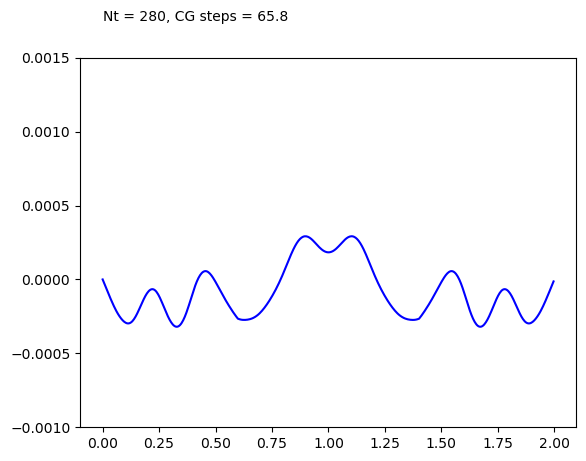

In [11]:
fig, ax = plt.subplots()
ln, = plt.plot(x[:-1], all_solutions[0], 'b')
ax.set_ylim([-0.001, 0.0015])
ax.text(0, 1.75e-3, f'Nt = {Nt}, CG steps = {np.mean(all_iters):.1f}')

def update(frame):
    y = all_solutions[frame]
    ln.set_ydata(y)
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(Nt), blit=True)
ani.save(f'elastodynamics_FE_CG_{Nt}_FFT.gif', writer='pillow')